In [317]:
import geopandas as gpd
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.offsetbox as offsetbox


from hidden_config import Config

Use API key and credentials to query Socrata database

In [318]:
url = "data.cityofchicago.org"
client = Socrata(url,
                 Config.API_KEY,
                 username=Config.USERNAME,
                 password=Config.PASSWORD)

red_light_violations_uri = 'spqx-js37'
speed_camera_violations_uri = 'hhkd-xvj4'

# default limit is 1000
red_light_violations_list = client.get(red_light_violations_uri, limit=1000000)
speed_camera_violations_list = client.get(speed_camera_violations_uri, limit=1000000)

red_light_violations_df = pd.DataFrame(red_light_violations_list)
speed_camera_violations_df = pd.DataFrame(speed_camera_violations_list)


### Data Cleansing
Cast the columns to their proper data types

In [319]:
speed_camera_violations_df['violations'] = speed_camera_violations_df['violations'].astype(float)
red_light_violations_df['violations'] = red_light_violations_df['violations'].astype(float)

speed_camera_violations_df['violation_date'] = pd.to_datetime(speed_camera_violations_df['violation_date'])
red_light_violations_df['violation_date'] = pd.to_datetime(red_light_violations_df['violation_date'])

speed_camera_violations_df['violation_day_of_week'] = speed_camera_violations_df['violation_date'].dt.strftime('%A')
red_light_violations_df['violation_day_of_week'] = pd.to_datetime(red_light_violations_df['violation_date']).dt.strftime('%A')

Drop the metadata columns the database adds

In [320]:
speed_cols_to_drop = speed_camera_violations_df.filter(like='@computed', axis=1)
speed_camera_violations_df.drop(columns=speed_cols_to_drop, axis=1, inplace=True)

red_light_cols_to_drop = red_light_violations_df.filter(like='@computed', axis=1)
red_light_violations_df.drop(columns=red_light_cols_to_drop, axis=1, inplace=True)

### Data Summary


In [321]:
print(f"There are {int(speed_camera_violations_df['violations'].sum())} speed camera violations and {int(red_light_violations_df['violations'].sum())} red light camera violations in this dataset.")
print(f"There are {speed_camera_violations_df['camera_id'].nunique()} speed cameras in the city. They issue {round(speed_camera_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day.")
print(f"There are {red_light_violations_df['camera_id'].nunique()} red light cameras in the city. They issue {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day.")

There are 15204580 speed camera violations and 5799837 red light camera violations in this dataset.
There are 181 speed cameras in the city. They issue 41.3 tickets per day.
There are 365 red light cameras in the city. They issue 6.2 tickets per day.


Consider the distribution of how many cameras are issuing tickets

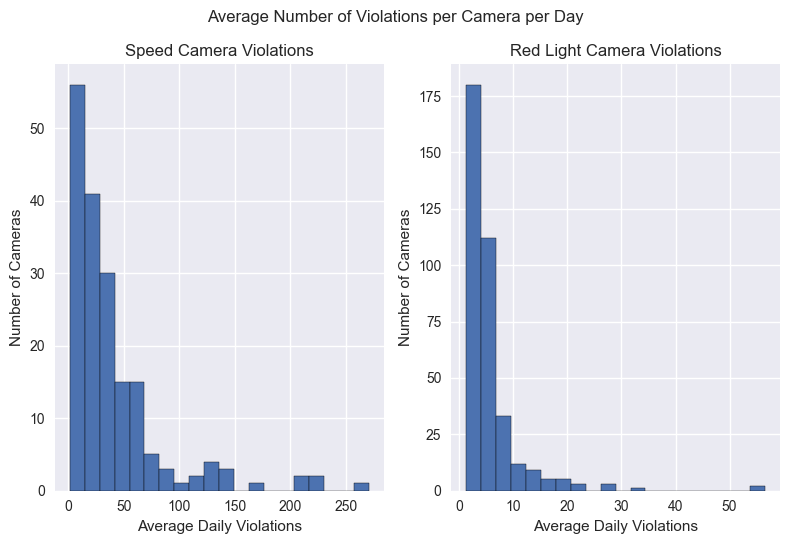

In [322]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

# Sum violations per camera per day. Take the average.
average_speed_violations_per_camera_per_day = speed_camera_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()
average_red_light_violations_per_camera_per_day = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()

ax[0].hist(average_speed_violations_per_camera_per_day, bins=20, edgecolor='black')
ax[0].set_title('Speed Camera Violations')

ax[1].hist(average_red_light_violations_per_camera_per_day, bins=20, edgecolor='black')
ax[1].set_title('Red Light Camera Violations')

for i in range(2):
  ax[i].set_xlabel('Average Daily Violations')
  ax[i].set_ylabel('Number of Cameras')

fig.suptitle('Average Number of Violations per Camera per Day')
plt.tight_layout()
plt.show()

In [323]:
camera_id_of_highest_rl_frequency = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().index[-1]
highest_average_rl_frequency = round(red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().values[-1],1)
intersection_of_highest_red_light_violations = red_light_violations_df[red_light_violations_df['camera_id'] == camera_id_of_highest_rl_frequency]['intersection'].unique()[0]

camera_id_of_highest_sc_frequency = speed_camera_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().index[-1]
highest_average_sc_frequency = round(speed_camera_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().values[-1],1)
intersection_of_highest_speed_violations = speed_camera_violations_df[speed_camera_violations_df['camera_id'] == camera_id_of_highest_sc_frequency]['address'].unique()[0]

print(f"We can see there is an outlier for both red light and speed camera violations. \
      \nOne red light camera is averaging {highest_average_rl_frequency} violations per day even though the average for the rest of the dataset is {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} violations per day. \
      \n This intersection is {intersection_of_highest_red_light_violations}. \
      \nOne speed camera is averaging {highest_average_sc_frequency} violations per day even though the average for the rest of the dataset is {round(speed_camera_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} violations per day. \
      \nThis intersection is {intersection_of_highest_speed_violations}.")


We can see there is an outlier for both red light and speed camera violations.       
One red light camera is averaging 56.6 violations per day even though the average for the rest of the dataset is 6.2 violations per day.       
 This intersection is CICERO AND I55.       
One speed camera is averaging 270.5 violations per day even though the average for the rest of the dataset is 41.3 violations per day.       
This intersection is 901 N CLARK ST.


### Temporal Analysis
Let's see how the number of violations trends over time.

Chicago is constantly installing more cameras. We can see how many unique camera_ids are present in each data set per month. This analysis assumes that each camera will have at least 1 violation per month in order to be represented in this analysis.

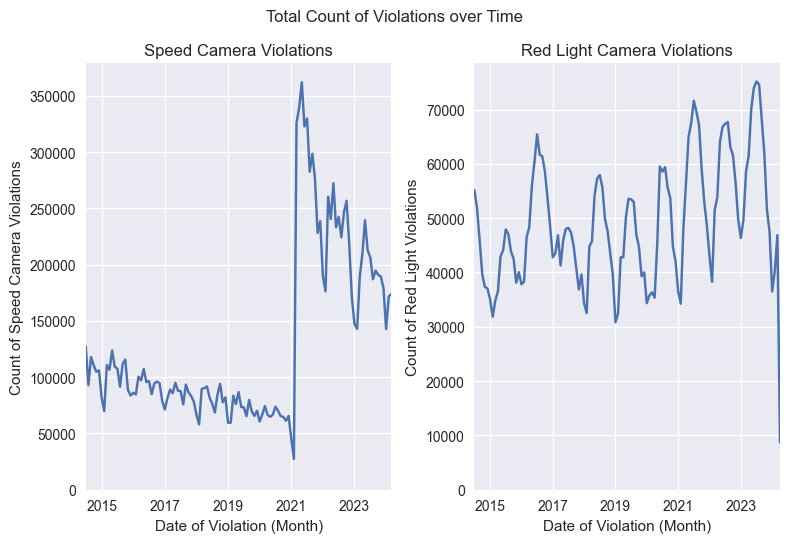

In [324]:
speed_camera_violations_df['violation_month'] = speed_camera_violations_df['violation_date'].dt.to_period('M')
total_speed_camera_violations_per_month = speed_camera_violations_df.groupby('violation_month')['violations'].sum().sort_index()

red_light_violations_df['violation_month'] = red_light_violations_df['violation_date'].dt.to_period('M')
total_red_light_camera_violations_per_month = red_light_violations_df.groupby('violation_month')['violations'].sum().sort_index()

fig, ax = plt.subplots(1, 2)

total_speed_camera_violations_per_month.plot(kind='line', ax=ax[0])
ax[0].set_title('Speed Camera Violations')
ax[0].set_ylabel('Count of Speed Camera Violations')

total_red_light_camera_violations_per_month.plot(kind='line', ax=ax[1])
ax[1].set_title('Red Light Camera Violations')
ax[1].set_ylabel('Count of Red Light Violations')

for i in range(2):
  ax[i].set_xlabel('Date of Violation (Month)')
  ax[i].set_ylim(0)  # Ensure y-axis starts at 0
  ax[i].set_xticks(ax[i].get_xticks()[::2])
plt.suptitle('Total Count of Violations over Time')
plt.tight_layout()


Let's note an interesting observations in these charts. We can see that the total count of speed violations appears to dip, then skyrocket in early 2021. The decline was caused by the city's COVID lockdown. The city's push for remote work caused a decline in traffic, which resulted in a reduction of driving violations. However, we can see there is a surge in speed camera violations in 2021. This was due to the city **reducing** the minimum speed required to be cited by a speed camera. Before 2021, the city would only cite drivers going >= 10 mph over the speed limit. However, in March 2021, they introduced another tier of tickets that would be issued to drivers going 6-10 mph over the speed limit. [source](https://abc7chicago.com/chicago-speed-camera-ticket-cameras-pay-speeding/13255936/)

### Seasonal Analysis
We can see from the charts so far that altough an overall trend may be apparent, there are still peaks and valleys within each time period. These fluctuations *may* be the result of random effects, but they could also be influenced by the **seasonality** factor. Considering the diverse weather conditions experience by Chicagoans throughout the year, it is plausible that driving behaviors vary between winter and summer.


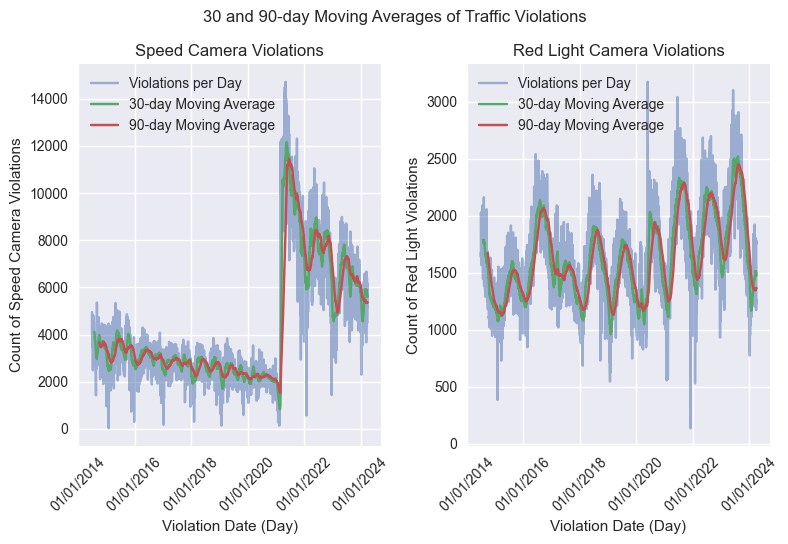

In [325]:
speed_camera_violations_df['30_day_ma'] = speed_camera_violations_df['violations'].rolling(window=30).mean()

fig, ax = plt.subplots(1, 2)

ax[0].plot(speed_camera_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day', alpha=0.5)

speed_camera_daily_sum = pd.DataFrame(speed_camera_violations_df.groupby('violation_date')['violations'].sum())
speed_camera_ma = speed_camera_daily_sum.rolling(window=30).mean()
ax[0].plot(speed_camera_ma['violations'], label='30-day Moving Average')
speed_camera_ma = speed_camera_daily_sum.rolling(window=90).mean()
ax[0].plot(speed_camera_ma['violations'], label='90-day Moving Average')

ax[0].tick_params(axis='x', rotation=45)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[0].set_xticks(ax[0].get_xticks()[::2])
ax[0].set_xlabel('Violation Date (Day)')
ax[0].set_ylabel('Count of Speed Camera Violations')
ax[0].set_title('Speed Camera Violations')
ax[0].legend()

ax[1].plot(red_light_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day', alpha=0.5)

red_light_daily_sum = pd.DataFrame(red_light_violations_df.groupby('violation_date')['violations'].sum())
red_light_ma = red_light_daily_sum.rolling(window=30).mean()
ax[1].plot(red_light_ma['violations'], label='30-day Moving Average')
red_light_ma = red_light_daily_sum.rolling(window=90).mean()
ax[1].plot(red_light_ma['violations'], label='90-day Moving Average')


ax[1].tick_params(axis='x', rotation=45)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[1].set_xticks(ax[1].get_xticks()[::2])
ax[1].set_xlabel('Violation Date (Day)')
ax[1].set_ylabel('Count of Red Light Violations')
ax[1].set_title('Red Light Camera Violations')
ax[1].legend()

plt.suptitle('30 and 90-day Moving Averages of Traffic Violations')

plt.tight_layout()
plt.show()

Consider how many violations per month for each year.

In [326]:
speed_camera_violations_df['violation_month_part'] = speed_camera_violations_df['violation_date'].dt.strftime('%B')
speed_camera_violations_df['violation_year_part'] = speed_camera_violations_df['violation_date'].dt.strftime('%Y')

sum_speed_months_by_year = speed_camera_violations_df.groupby(['violation_month_part','violation_year_part'])['violations'].sum()
sum_speed_months_by_year = sum_speed_months_by_year.reset_index()

red_light_violations_df['violation_month_part'] = red_light_violations_df['violation_date'].dt.strftime('%B')
red_light_violations_df['violation_year_part'] = red_light_violations_df['violation_date'].dt.strftime('%Y')

sum_red_light_months_by_year = red_light_violations_df.groupby(['violation_month_part','violation_year_part'])['violations'].sum()
sum_red_light_months_by_year = sum_red_light_months_by_year.reset_index()

In [327]:
# Create month categories
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
sum_speed_months_by_year['violation_month_part'] = pd.Categorical(sum_speed_months_by_year['violation_month_part'], categories=months, ordered=True)

# Sort the DataFrame by 'violation_month_part'
sum_speed_months_by_year = sum_speed_months_by_year.sort_values('violation_month_part')

sum_red_light_months_by_year['violation_month_part'] = pd.Categorical(sum_red_light_months_by_year['violation_month_part'], categories=months, ordered=True)
sum_red_light_months_by_year = sum_red_light_months_by_year.sort_values('violation_month_part')


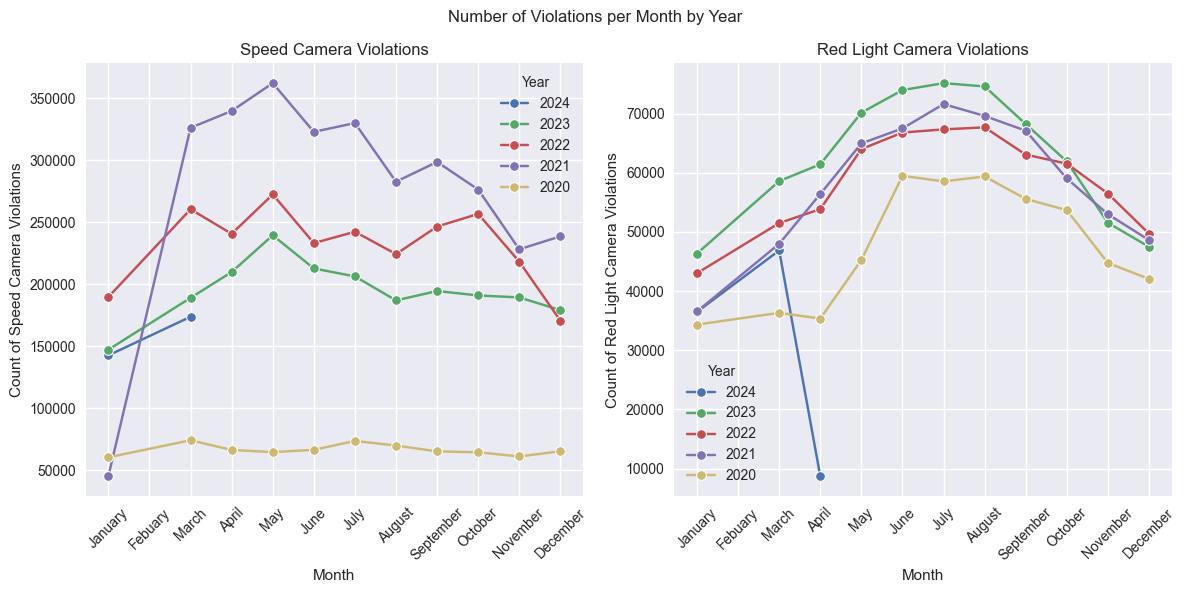

In [328]:
# The line chart gets a bit cluttered if there are more than 5 series displayed at a time. For simplicity, only the 5 most recent years are displayed
recent_years = np.sort(sum_speed_months_by_year['violation_year_part'].unique())[-5:]

sum_speed_months_by_year_recent = sum_speed_months_by_year[sum_speed_months_by_year['violation_year_part'].isin(recent_years)]
sum_red_light_months_by_year_recent = sum_red_light_months_by_year[sum_red_light_months_by_year['violation_year_part'].isin(recent_years)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=sum_speed_months_by_year_recent, x='violation_month_part', y='violations', hue='violation_year_part', marker='o', ax=ax[0])

ax[0].set_xlabel('Month')
ax[0].set_ylabel('Count of Speed Camera Violations')
ax[0].set_title('Speed Camera Violations')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(title='Year')

sns.lineplot(data=sum_red_light_months_by_year_recent, x='violation_month_part', y='violations', hue='violation_year_part', marker='o', ax=ax[1])

ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count of Red Light Camera Violations')
ax[1].set_title('Red Light Camera Violations')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(title='Year')

plt.suptitle('Number of Violations per Month by Year')
plt.tight_layout()
plt.show()



Note that the highest count of speed camera violations begin when the law was passed that reduce the threshold for tickets from 10 mph over the limit to 6 mph over. Took a lot of Chicagoans by surprise for the first couple months, especially as we transitioned into our first summer after the COVID lockdown, but they eventually figured it out by 2022. Keep in mind that it takes a few weeks to review the video of the tickets, so most people were probably getting ticketed without knowing it, so the delay in feedback from the city to the citizens was profitable for the city.

### DoW Analysis

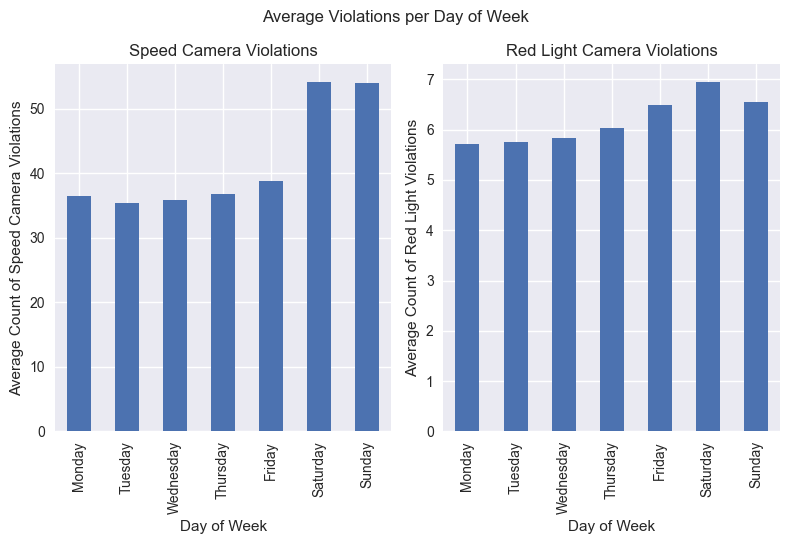

In [329]:
# Avg violations by day of week
avg_speed_camera_violations_by_dow = speed_camera_violations_df.groupby(['violation_day_of_week'])['violations'].mean()

# Do the same for red light cameras
avg_red_light_violations_by_dow = red_light_violations_df.groupby(['violation_day_of_week'])['violations'].mean()

# Create a Categorical data type with the desired order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_order = pd.CategoricalDtype(categories=day_order, ordered=True)

avg_speed_camera_violations_by_dow.index = avg_speed_camera_violations_by_dow.index.astype(cat_order)
avg_red_light_violations_by_dow.index = avg_red_light_violations_by_dow.index.astype(cat_order)

fig, ax = plt.subplots(1, 2)

avg_speed_camera_violations_by_dow.sort_index().plot(kind='bar', ax=ax[0])
avg_red_light_violations_by_dow.sort_index().plot(kind='bar', ax=ax[1])

ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Average Count of Speed Camera Violations')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Average Count of Red Light Violations')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Average Violations per Day of Week')
plt.tight_layout()
plt.show()


In [330]:
# Calculate how many percent each day is above or below the mean violations per day
print(round(((avg_speed_camera_violations_by_dow - avg_speed_camera_violations_by_dow.mean())/avg_speed_camera_violations_by_dow.mean()).sort_values(ascending=False),2))
print(pd.Series(round(avg_speed_camera_violations_by_dow/avg_speed_camera_violations_by_dow.sum(),2)).sort_values(ascending=False))

violation_day_of_week
Saturday     0.30
Sunday       0.30
Friday      -0.07
Thursday    -0.11
Monday      -0.12
Wednesday   -0.14
Tuesday     -0.15
Name: violations, dtype: float64
violation_day_of_week
Saturday     0.19
Sunday       0.19
Friday       0.13
Monday       0.13
Thursday     0.13
Tuesday      0.12
Wednesday    0.12
Name: violations, dtype: float64


We can see that the average number of violations per day are 30% higher than average on the weekends. Saturday and Sunday make up for almost 40% of all speed camera violations.

### Chicago Communities

In [331]:
# Group by latitude and longitude so we don't repeat operations unnecessarily on the next step.
speed_camera_violations_df_by_coords = pd.DataFrame(speed_camera_violations_df.groupby(['latitude','longitude'])['violations'].sum()).reset_index()
red_light_violations_df_by_coords = pd.DataFrame(red_light_violations_df.groupby(['latitude','longitude'])['violations'].sum()).reset_index()


/Users/charles/Projects/chicago-traffic-violations/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/vs/jrf2271n7xjdd7zy9n_nl2gw0000gn/T/ipykernel_41692/3526191726.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  violations_with_neighborhood_speed = gpd.sjoin(gdf_speed_camera_violations, neighborhoods, how="left", op="within")
/Users/charles/Projects/chicago-traffic-violations/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await s

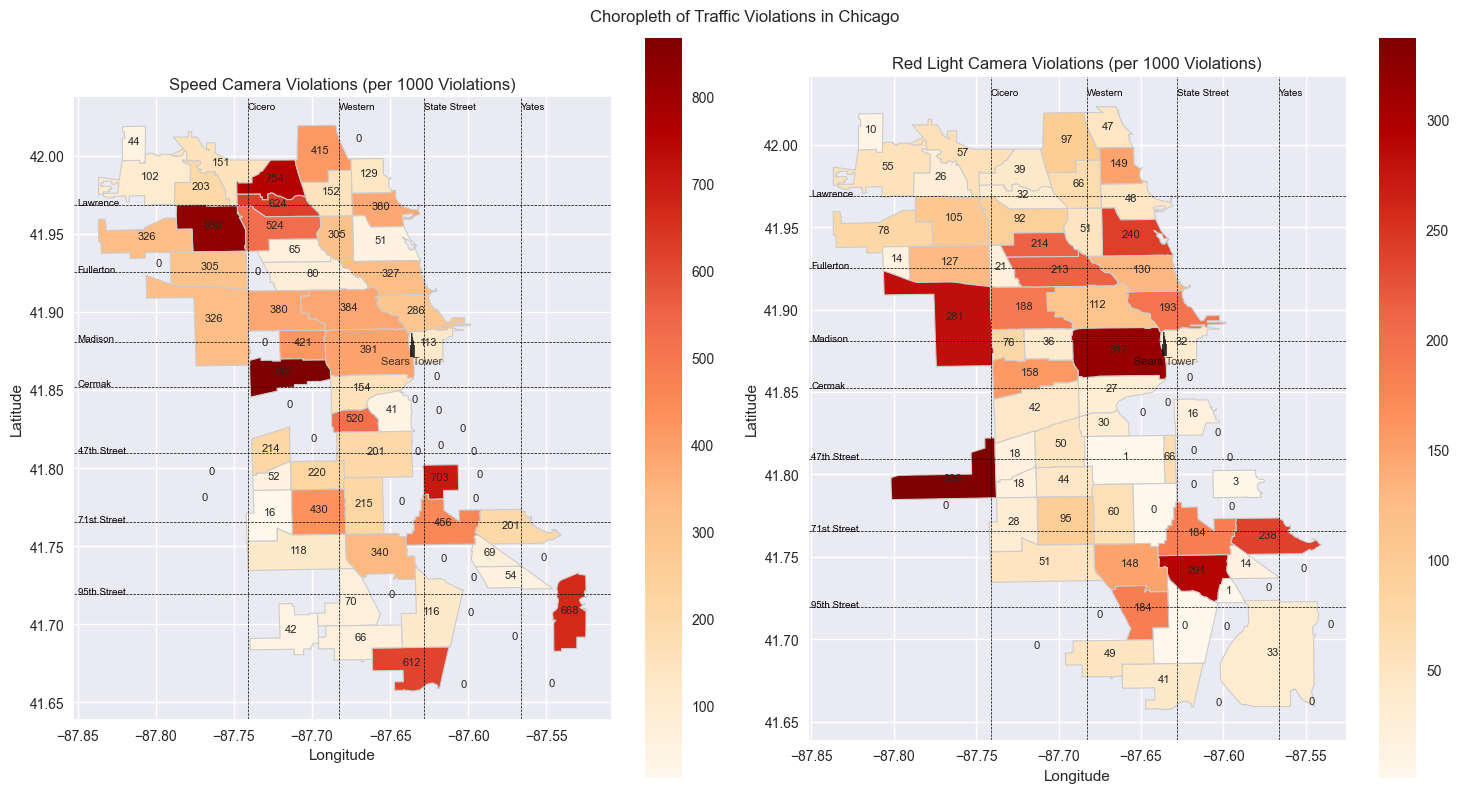

In [332]:
import geopandas as gpd
import matplotlib.pyplot as plt

scale_results = 1000

neighborhoods = gpd.read_file("chicago_neighborhood_2024.geojson")

gdf_speed_camera_violations = gpd.GeoDataFrame(speed_camera_violations_df_by_coords, 
                                                geometry=gpd.points_from_xy(speed_camera_violations_df_by_coords['longitude'], 
                                                                            speed_camera_violations_df_by_coords['latitude']))

# Perform spatial join for speed camera violations
violations_with_neighborhood_speed = gpd.sjoin(gdf_speed_camera_violations, neighborhoods, how="left", op="within")
violations_by_neighborhood_speed = violations_with_neighborhood_speed.groupby('community')['violations'].sum().reset_index(name='violations')
violations_by_neighborhood_speed['violations'] = violations_by_neighborhood_speed['violations']/scale_results

# Create GeoDataFrame for red light violations
gdf_red_light_violations = gpd.GeoDataFrame(red_light_violations_df_by_coords, 
                                             geometry=gpd.points_from_xy(red_light_violations_df_by_coords['longitude'], 
                                                                         red_light_violations_df_by_coords['latitude']))

# Perform spatial join for red light violations
violations_with_neighborhood_red = gpd.sjoin(gdf_red_light_violations, neighborhoods, how="left", op="within")
violations_by_neighborhood_red = violations_with_neighborhood_red.groupby('community')['violations'].sum().reset_index(name='violations')
violations_by_neighborhood_red['violations'] = violations_by_neighborhood_red['violations']/scale_results

# Create figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot speed camera violations
merged_df_speed = neighborhoods.merge(violations_by_neighborhood_speed, on='community', how='left')
merged_df_speed.plot(column='violations', cmap='OrRd', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title(f'Speed Camera Violations (per {scale_results} Violations)')

# Plot red light violations
merged_df_red = neighborhoods.merge(violations_by_neighborhood_red, on='community', how='left')
merged_df_red.plot(column='violations', cmap='OrRd', linewidth=0.8, ax=ax2, edgecolor='0.8', legend=True)
ax2.set_title(f'Red Light Camera Violations (per {scale_results} Violations)')

# Need to clean data so we can round to int
merged_df_speed['violations'] = merged_df_speed['violations'].fillna(0)
merged_df_speed['violations'] = merged_df_speed['violations'].replace([np.inf,-np.inf],0)
merged_df_speed['violations'] = merged_df_speed['violations'].astype(int)

merged_df_red['violations'] = merged_df_red['violations'].fillna(0)
merged_df_red['violations'] = merged_df_red['violations'].replace([np.inf,-np.inf],0)
merged_df_red['violations'] = merged_df_red['violations'].astype(int)

# annotate the neighborhoods
for idx, row in merged_df_speed.iterrows():
    ax1.annotate(text=row['violations'], xy=row.geometry.centroid.coords[0], ha='center', fontsize=8)
for idx, row in merged_df_red.iterrows():
    ax2.annotate(text=row['violations'], xy=row.geometry.centroid.coords[0], ha='center', fontsize=8)


# Set common properties for both subplots
for ax in [ax1, ax2]:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')
    
    sears_tower_latitude, sears_tower_longitude = -87.635918, 41.878876
    sears_tower_icon = offsetbox.OffsetImage(plt.imread('icons/sears_tower.png'), zoom=0.1, alpha=.8) 
    st = offsetbox.AnnotationBbox(sears_tower_icon, (sears_tower_latitude, sears_tower_longitude),
                                   frameon=False, xycoords='data', boxcoords="data", pad=0)
    ax.add_artist(st)
    ax.text(sears_tower_latitude, sears_tower_longitude - 0.01, 'Sears Tower', ha='center', va='center',
            fontsize=8, color='black', alpha=0.7)

    # Northside E/W streets
    ax.axhline(y=41.881049, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.85, 41.881049, 'Madison', ha='left', color='black', size=7)
    ax.axhline(y=41.925438, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.85, 41.925438, 'Fullerton', ha='left', color='black', size=7)
    ax.axhline(y=41.968750, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.85, 41.968750, 'Lawrence', ha='left', color='black', size=7)

    # Southside E/W streets
    ax.axhline(y=41.852248, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.85, 41.852248, 'Cermak', ha='left', color='black', size=7)
    ax.axhline(y=41.809462, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.85, 41.809462, '47th Street', ha='left', color='black', size=7)
    ax.axhline(y=41.765748, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.85, 41.765748, '71st Street', ha='left', color='black', size=7)
    ax.axhline(y=41.719385, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.85, 41.719385, '95th Street', ha='left', color='black', size=7)

    # N/S Streets
    ax.axvline(x=-87.628037, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.628037, 42.03, 'State Street', ha='left', color='black', size=7)
    ax.axvline(x=-87.682922, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.682922, 42.03, 'Western', ha='left', color='black', size=7)
    ax.axvline(x=-87.740997, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.740997, 42.03, 'Cicero', ha='left', color='black', size=7)
    ax.axvline(x=-87.566060, color='black', linestyle='--', linewidth=.5)
    ax.text(-87.566060, 42.03, 'Yates', ha='left', color='black', size=7)

plt.suptitle('Choropleth of Traffic Violations in Chicago')
plt.tight_layout()
plt.show()


In [344]:
merged_df_red[['community','violations']].sort_values('violations', ascending=False)

,community,violations
54,GARFIELD RIDGE,336
28,NEAR WEST SIDE,317
39,CHATHAM,291
25,AUSTIN,281
44,LAKE VIEW,240
...,...,...
45,CALUMET HEIGHTS,0
46,ROSELAND,0
48,PULLMAN,0
53,HEGEWISCH,0
